In [207]:
%matplotlib inline
import matplotlib.pyplot as plt

In [208]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.autograd import Variable

torch.manual_seed(1)

In [209]:
from nltk.tokenize import word_tokenize

#### Input and tokenize some raw data

In [210]:
raw_text = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells.""".lower()

token_text = word_tokenize(raw_text)

print(len(token_text), token_text[:10])

70 ['we', 'are', 'about', 'to', 'study', 'the', 'idea', 'of', 'a', 'computational']


#### Data preprocessing (word to index, index to word, freq. dictionary, subsampling)

In [211]:
# set of vocab items
vocab = set(token_text)
vocab_size = len(vocab)
print("size of vocabulary: ", vocab_size)

# dictionaries mapping from word to index and vica versa
word_to_ix = {word: i for i, word in enumerate(vocab)}
ix_to_word = {i: word for i, word in enumerate(vocab)}

size of vocabulary:  46


In [212]:
# global variables for subsampling
THRESHOLD = 0.001
RAND = np.random.sample()

def word_freqs(text, subsampling=True):
    """
    creates a word frequency dictionary of tokenized text, optionally subsamples from tokenized text
    
    args:
        text (list): list of words from tokenized text
        subsampling (bool): whether to use subsampling of frequent words (see [1])
    returns:
        (subsampled) tokenized text
        freq_dict (dict): frequency dictionary of tokenized text
    """
    freq_dict = {}
    for word in text:
        if word not in freq_dict:
            freq_dict[word] = 0
        freq_dict[word] += 1.0
        
    # subsampling: if a given word has a high(er than some random number) relative frequency, then discard it
    if subsampling:
        print("random number used for subsampling:", round(RAND, 5))
        print("discarded (ie. high-frequency) words:")
        for i, word in enumerate(text):
            prob_discard = 1 - np.sqrt(THRESHOLD * len(freq_dict.keys()) / freq_dict[word])   # probability of word being discarded
            if (RAND <= prob_discard):
                print(round(prob_discard, 5), word)
                del [text[i]]
                i -= 1
        print("length of tokenized text after subsampling: ", len(text))
    return text, freq_dict

token_text, freq_dict = word_freqs(token_text)
    

# distribution of frequencies (list)
freq_distr = [freq_dict[ix_to_word[i]] for i in range(len(freq_dict))]
#print(freq_distr)


random number used for subsampling: 0.54287
discarded (ie. high-frequency) words:
0.84834 we
0.78552 about
0.78552 study
0.78552 idea
0.89276 a
0.84834 process
0.84834 computational
0.84834 are
0.78552 beings
0.78552 inhabit
0.91244 .
0.78552 they
0.84834 ,
0.78552 manipulate
0.84834 abstract
0.84834 called
0.91244 .
0.78552 evolution
0.89276 a
0.78552 is
0.78552 by
0.78552 pattern
0.78552 rules
0.89276 a
0.91244 .
0.78552 create
0.84834 to
0.87617 processes
0.78552 in
0.84834 ,
0.78552 conjure
0.78552 spirits
0.89276 the
0.78552 with
0.78552 spells
length of tokenized text after subsampling:  35


#### Data processing for Skip-Gram and CBOW, with negative sampling

In [213]:
# global variables for data processing
CONTEXT_SIZE = 2
NUM_NEG_SAMPLES = 10
MODEL = "skipgram" #or "cbow"
        
def create_dataset(text, word_to_ix, context_size=CONTEXT_SIZE, model=MODEL):
    """
    creates dataset in accordance with the Skip-gram and CBOW models
    
    args:
        text (list): list of words from tokenized text
        word_to_ix (dict): word to index dictionary
        context_size (int): size of window to one side
        model (str): either "skipgram" or "cbow"
        
    returns:
        data (list of tuples): dataset according to Skip-gram or CBOW principles
            Skip-gram: ([center word index], context word index)
            CBOW: ([indices of context words], center word index)
    """
    data = []
    for ix, word in enumerate(text):
        # forward and backward counters and indices
        back_counter, for_counter = 0, 0
        back_ix, for_ix = ix - 1, ix + 1
        if model == "skipgram":
            # while we're within the context window, append data w/ positive examples
            while 0 <= back_ix and back_counter < context_size:
                data.append(([word_to_ix[word]], word_to_ix[text[back_ix]])) # ([center word ix], context word ix)
                back_ix -= 1
                back_counter += 1
            while for_ix < len(text) and for_counter < context_size:
                data.append(([word_to_ix[word]], word_to_ix[text[for_ix]]))
                for_ix += 1
                for_counter += 1

        elif model == "cbow":
            # define context comprising words that are surrounding the center word
            # then append it
            context = []
            while 0 <= back_ix and back_counter < context_size:
                context.append(word_to_ix[text[back_ix]])
                back_ix -= 1
                back_counter += 1
            while for_ix < len(text) and for_counter < context_size:
                context.append(word_to_ix[text[for_ix]])
                for_ix += 1
                for_counter += 1
            # append data with ([context], center word ix):
            data.append((context, word_to_ix[word]))
    return data

def neg_sampling(ix_to_word, freq_distr, num_neg_samples=NUM_NEG_SAMPLES):
    ## weighted unigram frequency
    # raised to 3/4th power and normalized
    freq_distr_norm = F.normalize(torch.Tensor(freq_distr).pow(0.75), dim=0)

    # initialize an all-one vec of size |V|×1 ~> weights 
    #NB. at the beginning, each word is a positive, so gets a weight of 1
    weights = torch.ones(len(freq_distr), 1)
    
    # for each positive word, generate num_neg_samples as many negative samples
    for _ in range(len(freq_distr)):
        for _ in range(num_neg_samples):
            neg_ix = torch.multinomial(freq_distr_norm, 1)[0] #Q. what if the negative sample happens to be a positive (ie. existing data)?
            weights[neg_ix] += 1
    return weights


data_skipgram = create_dataset(token_text, word_to_ix, context_size=CONTEXT_SIZE, model="skipgram")
data_cbow = create_dataset(token_text, word_to_ix, context_size=CONTEXT_SIZE, model="cbow")
weights = neg_sampling(ix_to_word, freq_distr, num_neg_samples=NUM_NEG_SAMPLES)
print("skipgram data count:", len(data_skipgram), "\nskipgram data sample:", data_skipgram[:10])
print("cbow data count:", len(data_cbow), "\ncbow data sample:", data_cbow[:10])
print("weights for each word after negative sampling", weights)

skipgram data count: 134 
skipgram data sample: [([21], 26), ([21], 38), ([26], 21), ([26], 38), ([26], 23), ([38], 26), ([38], 21), ([38], 23), ([38], 25), ([23], 38)]
cbow data count: 35 
cbow data sample: [([26, 38], 21), ([21, 38, 23], 26), ([26, 21, 23, 25], 38), ([38, 26, 25, 40], 23), ([23, 38, 40, 27], 25), ([25, 23, 27, 41], 40), ([40, 25, 41, 15], 27), ([27, 40, 15, 2], 41), ([41, 27, 2, 39], 15), ([15, 41, 39, 34], 2)]
weights for each word after negative sampling tensor([[ 8.],
        [ 7.],
        [ 7.],
        [ 5.],
        [ 6.],
        [16.],
        [ 9.],
        [ 8.],
        [ 8.],
        [10.],
        [14.],
        [ 8.],
        [ 3.],
        [18.],
        [12.],
        [ 6.],
        [10.],
        [ 9.],
        [ 8.],
        [11.],
        [ 8.],
        [ 6.],
        [ 9.],
        [26.],
        [ 8.],
        [18.],
        [11.],
        [23.],
        [ 9.],
        [ 6.],
        [ 5.],
        [11.],
        [ 7.],
        [15.],
        [ 

#### Define models

In [214]:
EMBEDDING_SIZE = 50

class SkipGram(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGram, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim) # embedding matrix of size |V|×d, where d is the size of embedding vectors
        self.linear = nn.Linear(embedding_dim, vocab_size) # linear layer
        
    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = self.linear(embeds)
        log_probs = F.log_softmax(out, dim=1) # apply log softmax over each column ==> vec of size 1×|V|
        return log_probs
    
    
class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim) 
        self.linear1 = nn.Linear(embedding_dim, vocab_size)

    def forward(self, inputs):
        embeds = torch.mean(self.embeddings(inputs), dim=0).view(1, -1) # take the mean of vectors of context words (over all rows) ==> vec of size 1×d
        out = self.linear1(embeds)
        log_probs = F.log_softmax(out, dim=1) 
        return log_probs


#### Training

In [215]:
LEARNING_RATE = 0.001
EPOCHS = 20

def train_skip_gram(data, weights):
    losses = []
    model = SkipGram(vocab_size, EMBEDDING_SIZE)
    loss_fn = nn.NLLLoss(weight=weights)
    #optimizer = optim.SGD(model.parameters(), LEARNING_RATE)
    optimizer = torch.optim.Adam(model.parameters(), LEARNING_RATE)

    for epoch in range(EPOCHS):
        total_loss = 0
        for context, target in data:
            context_var = Variable(torch.LongTensor(context))
            target_var = Variable(torch.LongTensor([target]))

            model.zero_grad()
            log_probs = model(context_var)
            loss = loss_fn(log_probs, target_var)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        losses.append(total_loss)
        
    # print an example embedding
    word = list(freq_dict.keys())[0]
    input = torch.autograd.Variable(torch.LongTensor([word_to_ix[word]]))
    print("an example embedding of '", word, "' trained with Skip-gram: ", model.embeddings(input).data[0])
    return model, losses


def train_cbow(data, weights):
    losses = []
    model = CBOW(vocab_size, EMBEDDING_SIZE)
    loss_fn = nn.NLLLoss(weight=weights)
    #optimizer = optim.SGD(model.parameters(), LEARNING_RATE)
    optimizer = torch.optim.Adam(model.parameters(), LEARNING_RATE)

    for epoch in range(EPOCHS):
        total_loss = 0
        for context, target in data:
            context_var = Variable(torch.LongTensor(context))
            target_var = Variable(torch.LongTensor([target]))
            
            model.zero_grad()
            log_probs = model(context_var)
            loss = loss_fn(log_probs, target_var)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        losses.append(total_loss)
    
    # print an example embedding
    word = list(freq_dict.keys())[0]
    input = torch.autograd.Variable(torch.LongTensor([word_to_ix[word]]))
    print("an example embedding of '", word, "' trained with CBOW: ", model.embeddings(input).data[0])
    return model, losses

skip_gram_model, skip_gram_losses = train_skip_gram(data_skipgram, weights)
cbow_model, cbow_losses = train_cbow(data_cbow, weights)
print(skip_gram_model)
print(cbow_model)

an example embedding of ' our ' trained with Skip-gram:  tensor([-7.1349e-01,  1.4296e+00, -4.0149e-01,  1.7090e+00, -1.1879e+00,
         3.7916e-01,  5.2712e-02, -3.2363e-01, -1.0842e+00, -1.0189e+00,
         1.1449e-01,  9.8969e-01,  1.5166e-03,  3.5434e-02,  1.2757e+00,
        -1.7873e+00,  1.4140e+00, -1.3263e+00,  1.0141e+00, -1.5681e+00,
        -5.1523e-01, -1.1264e+00,  1.9136e+00,  1.9841e-01,  5.6155e-02,
        -1.3283e-02,  9.9777e-01, -4.9598e-01,  8.0531e-01, -1.8616e+00,
        -7.6723e-01,  1.6134e+00, -1.4284e+00,  3.0089e+00,  6.0521e-01,
         9.7906e-01,  2.8048e+00,  1.5130e+00, -3.7982e-01, -5.9734e-01,
         3.0410e-01,  9.4978e-01, -3.2633e-02,  3.3832e-01, -3.8687e-01,
        -1.2456e+00, -1.4844e+00,  7.0881e-01, -1.1518e+00, -8.1747e-01])
an example embedding of ' our ' trained with CBOW:  tensor([ 3.1244e-01,  5.8872e-01,  3.4466e-01,  3.9039e-01, -7.4655e-01,
         6.2555e-01,  3.7278e-01,  9.9874e-01, -8.0956e-02, -3.1281e-01,
        -2.007

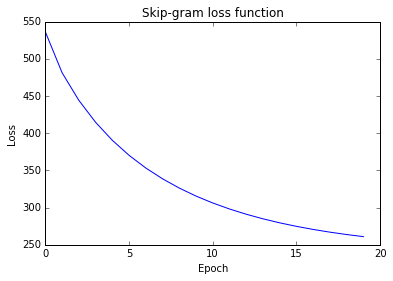

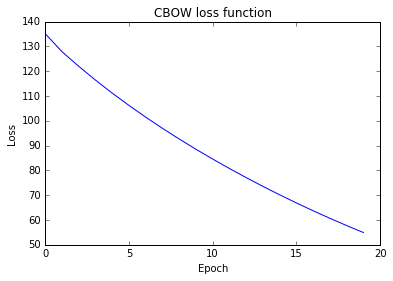

In [216]:
def plot_loss_fn(losses, title):
    plt.plot(range(len(losses)), losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.figure()

plot_loss_fn(skip_gram_losses, "Skip-gram loss function")
plot_loss_fn(cbow_losses, "CBOW loss function")

#### Testing (only on training data, which is due to the small size of raw data)

In [217]:
def test_model(test_data, model):
    correct_counter = 0
    for context, target in test_data:
        context_var = Variable(torch.LongTensor(context))

        model.zero_grad()
        log_probs = model(context_var)
        _, predicted = torch.max(log_probs.data, 1)
        predicted_word = ix_to_word[predicted[0].item()]
        print('predicted:', predicted_word)
        print('label    :', ix_to_word[target])
        if predicted_word == ix_to_word[target]:
            correct_counter += 1

    print('Accuracy: {:.1f}% ({:d}/{:d})'.format(correct_counter/len(test_data)*100, correct_counter, len(test_data)))

In [218]:
test_model(data_skipgram, skip_gram_model)
test_model(data_cbow, cbow_model)

predicted: to
label    : to
predicted: to
label    : the
predicted: are
label    : are
predicted: are
label    : the
predicted: are
label    : of
predicted: of
label    : to
predicted: of
label    : are
predicted: of
label    : of
predicted: of
label    : computational
predicted: the
label    : the
predicted: the
label    : to
predicted: the
label    : computational
predicted: the
label    : .
predicted: .
label    : of
predicted: .
label    : the
predicted: .
label    : .
predicted: .
label    : processes
predicted: we
label    : computational
predicted: we
label    : of
predicted: we
label    : processes
predicted: we
label    : abstract
predicted: things
label    : .
predicted: things
label    : computational
predicted: things
label    : abstract
predicted: things
label    : that
predicted: that
label    : processes
predicted: that
label    : .
predicted: that
label    : that
predicted: that
label    : computers
predicted: as
label    : abstract
predicted: as
label    : processes
pr

In [219]:
## References
# [1] Mikolov et al.: Distributed representations of words and phrases and their compositionality
# Mikolov et al.: Efficient estimation of word representations in vector space
# Jurafsky & Martin: Speech and Language Processing, Chapter 6
# https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html#sphx-glr-beginner-nlp-word-embeddings-tutorial-py
# https://github.com/dthiagarajan/word2vec-pytorch
# https://github.com/jojonki/word2vec-pytorch